In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import itertools
import random
random.seed(108448)
from scipy.stats import foldnorm, norm
import matplotlib.pyplot as plt

#%pip install gurobipy
import gurobipy as gp
from gurobipy import GRB


Data generation

In [39]:
#Define the number of elements in each set I, J, K
i_num = 10
k_num = 1
j_num = 200 #Without I and K, so real j_num_real = j_num + i_num + k_num
degree_to_m = 111111

#Define empty data frames
I = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])
J = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])
K = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])



In [40]:
#Define sets of I, J, K, where J contains I and K

for i in range(i_num):
    I.loc[i, 'Point number'] = 'i'+ str(i)
    I.loc[i, 'Latitude'] = round(random.uniform(0, 3000), 0)
    I.loc[i, 'Longitude'] = round(random.uniform(0, 3000), 0)

I.index = I['Point number']


for k in range(k_num):
    K.loc[k, 'Point number'] = 'k'+ str(k)
    K.loc[k, 'Latitude'] = round(random.uniform(0, 3000), 0)
    K.loc[k, 'Longitude'] = round(random.uniform(0, 3000), 0)

K.index = K['Point number']


for j in range(j_num):
    J.loc[j, 'Point number'] = 'j'+ str(j)
    J.loc[j, 'Latitude'] = round(random.uniform(0, 3000), 0)
    J.loc[j, 'Longitude'] = round(random.uniform(0, 3000), 0)

J.index = J['Point number']
J = pd.concat([J, K, I], axis = 0) #Include K to J
J

,Point number,Latitude,Longitude
Point number,,,
j0,j0,1782.0,970.0
j1,j1,2488.0,2484.0
j2,j2,2925.0,2878.0
j3,j3,2423.0,2429.0
j4,j4,1487.0,1307.0
...,...,...,...
i5,i5,2295.0,2106.0
i6,i6,598.0,660.0
i7,i7,1820.0,2908.0


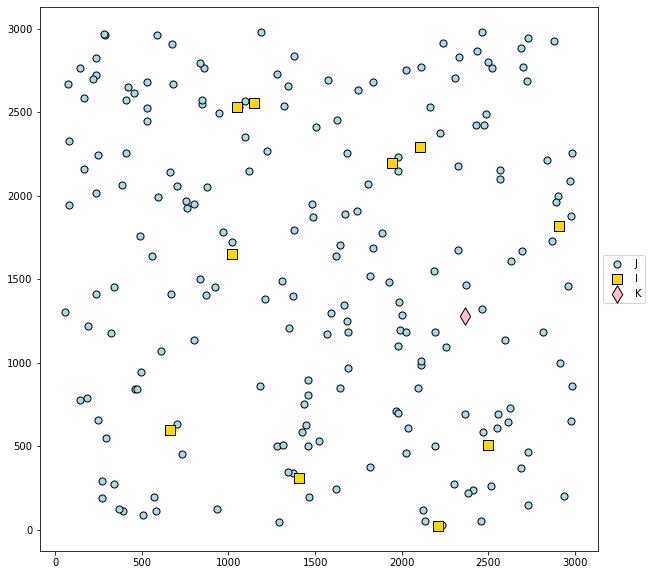

In [41]:
axs, fig = plt.subplots(1, 1, figsize = (10, 10))

fig.scatter(J['Longitude'], J['Latitude'], color = 'lightblue', edgecolors = 'black',
            marker = 'o', s = 50, label = 'J')
fig.scatter(I['Longitude'], I['Latitude'], color = 'gold', edgecolors = 'black',
            marker = 's', s = 100, label = 'I')
fig.scatter(K['Longitude'], K['Latitude'], color = 'pink', edgecolors = 'black',
            marker = 'd', s = 150, label = 'K')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [42]:
#Define constants

B = 91800 #battery load: meters of travel
S = 1020 #meters of service time
W = 2500 #max grams of weight

p = 0.95

alpha = 15900 #euro

beta = {}
for j in J.index:
    if j.startswith('j'):
        beta[j] = 203000
    else:
        beta[j] = 76920

gamma = 0.0045 / 1000 # variable cost in euro per m

q_j = {}
for j in J.index:
    if j.startswith('j'):
        q_j[j] = 255
    else:
        q_j[j] = 45



softlimit = 200
hardlimit = 600

In [43]:
#Model termination function

def softtime(model, where):
    if where == GRB.Callback.MIP:
        runtime = model.cbGet(GRB.Callback.RUNTIME)
        objbst = model.cbGet(GRB.Callback.MIP_OBJBST)
        objbnd = model.cbGet(GRB.Callback.MIP_OBJBND)
        gap = abs((objbst - objbnd) / objbst)

        if runtime > softlimit and gap < 0.5:
            model.terminate()

In [44]:
std_dev = {i : random.uniform(2000, 5000) for i in I.index}

#Define random variable

theta_ran_i = {}
for i in list(I.index):
    theta_ran_i[i] = foldnorm(c=0, loc=0, scale=std_dev[i]) 
    
#Define deterministic theta
theta_det = {}
for i in I.index:
    theta_det[i] = theta_ran_i[i].rvs(1)[0]
    
r = len(theta_ran_i.keys()) #r-variate random vector theta

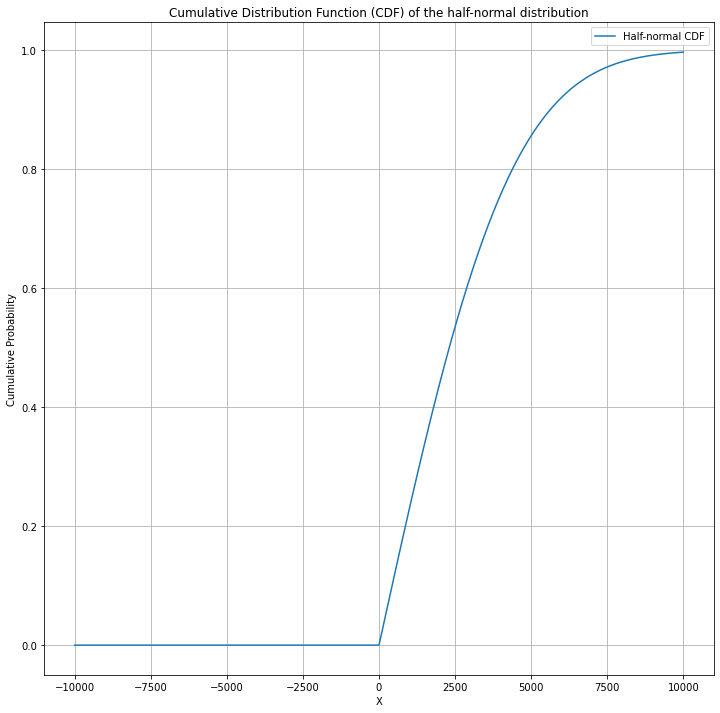

In [45]:
x = np.linspace(-10000, 10000, 1000)  # Generate 1000 points from 0 to 5
cdf = theta_ran_i['i0'].cdf(x)
plt.figure(figsize=(12, 12))
plt.plot(x, cdf, label='Half-normal CDF')
plt.title('Cumulative Distribution Function (CDF) of the half-normal distribution')
plt.xlabel('X')
plt.ylabel('Cumulative Probability')
plt.grid(True)
plt.legend()
plt.show()

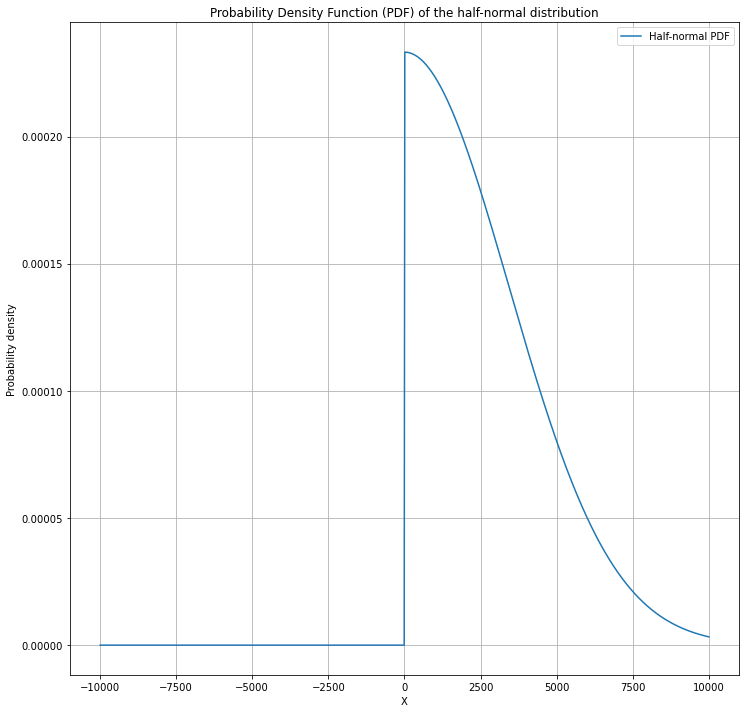

In [46]:
x = np.linspace(-10000, 10000, 1000)  # Generate 1000 points from 0 to 5
pdf = theta_ran_i['i0'].pdf(x)
plt.figure(figsize=(12, 12))
plt.plot(x, pdf, label='Half-normal PDF')
plt.title('Probability Density Function (PDF) of the half-normal distribution')
plt.xlabel('X')
plt.ylabel('Probability density')
plt.grid(True)
plt.legend()
plt.show()

Deterministic model DM

In [47]:
#Define distance matrices

def distance(point1, PointsSet1, point2, PointsSet2):
    c1 = np.array((PointsSet1.loc[point1, 'Longitude'], PointsSet1.loc[point1, 'Latitude']))
    c2 = np.array((PointsSet2.loc[point2, 'Longitude'], PointsSet2.loc[point2, 'Latitude']))
    return np.linalg.norm(c1-c2)

dist_JI = {(c1, c2): distance(c1, J, c2, I)for c1, c2 in itertools.product(J.index, I.index)}
dist_IK = {(c1, c2): distance(c1, I, c2, K)for c1, c2 in itertools.product(I.index, K.index)}
dist_KJ = {(c1, c2): distance(c1, K, c2, J)for c1, c2 in itertools.product(K.index, J.index)}

dist_KJ


{('k0', 'j0'): 1479.4137352343325,
 ('k0', 'j1'): 1213.150031941639,
 ('k0', 'j2'): 1723.0763186812126,
 ('k0', 'j3'): 1143.9637232010464,
 ('k0', 'j4'): 1074.923718223763,
 ('k0', 'j5'): 481.84852391597093,
 ('k0', 'j6'): 1125.6309341875783,
 ('k0', 'j7'): 1766.4079370292695,
 ('k0', 'j8'): 2311.76209848678,
 ('k0', 'j9'): 1977.4175077610696,
 ('k0', 'j10'): 1989.4705325789573,
 ('k0', 'j11'): 1022.9667638784751,
 ('k0', 'j12'): 1617.8729863620322,
 ('k0', 'j13'): 424.51972863460657,
 ('k0', 'j14'): 1839.294701781093,
 ('k0', 'j15'): 2552.4272761432403,
 ('k0', 'j16'): 2571.4108967646534,
 ('k0', 'j17'): 1905.2359433938884,
 ('k0', 'j18'): 2324.332377264491,
 ('k0', 'j19'): 1781.4269561225349,
 ('k0', 'j20'): 2309.2918828073684,
 ('k0', 'j21'): 2029.1338053465079,
 ('k0', 'j22'): 1657.605501921371,
 ('k0', 'j23'): 963.0129801825103,
 ('k0', 'j24'): 883.8880019549988,
 ('k0', 'j25'): 2044.4962704783788,
 ('k0', 'j26'): 1254.4018494884324,
 ('k0', 'j27'): 857.1300951430885,
 ('k0', 'j28

In [48]:
def ListSolution(model):
        nSolutions = model.SolCount
        print('Number of solutions found: ' + str(nSolutions))
        for e in range(nSolutions):
        #for iter2 in range(1):
                model.setParam(GRB.Param.SolutionNumber, e)
                print(e)
                print('%g ' % model.PoolObjVal, end='\n')
                for v in model.getVars():
                        if v.X > 0:
                                print ('%s %g' % (v.varName, int(v.X)))
                                #print(v)
                print("\n")

        print("\n")


In [49]:
def SolutionSummary(model):
    n = -1
    results = pd.DataFrame(columns = ['i', 'k', 'j', 'Number of drones'])
    for opt_sol in range(1):
        for v in model.getVars():
            if v.varName.startswith('x_ikj'):
                if v.X > 0:
                    n += 1
                    indices = v.varName[6:-1].split(',') #drop variable name and brackets and convert to a list of indices
                    results.loc[n, 'i'] = indices[0]
                    results.loc[n, 'k'] = indices[1]
                    results.loc[n, 'j'] = indices[2]
                    results.loc[n, 'Number of drones'] = int(v.X)
    results_doctors = results.groupby('i', as_index = False)['Number of drones'].sum()
    results_locations = results.groupby('j', as_index = False)['Number of drones'].sum()
    results_labs = results.groupby('k', as_index = False)['Number of drones'].sum()
    total_drones = sum(results['Number of drones'])
    total_locations = results['j'].nunique()
    return results_doctors, results_locations, results_labs, f'Total number of drones: {total_drones}', f'Total number of locations: {total_locations}'


In [50]:
#Redefine set L
L = list()
for k, j in itertools.product(K.index, J.index):
    if dist_KJ[(k, j)] <= B:
        L.append((k, j))

L

[('k0', 'j0'),
 ('k0', 'j1'),
 ('k0', 'j2'),
 ('k0', 'j3'),
 ('k0', 'j4'),
 ('k0', 'j5'),
 ('k0', 'j6'),
 ('k0', 'j7'),
 ('k0', 'j8'),
 ('k0', 'j9'),
 ('k0', 'j10'),
 ('k0', 'j11'),
 ('k0', 'j12'),
 ('k0', 'j13'),
 ('k0', 'j14'),
 ('k0', 'j15'),
 ('k0', 'j16'),
 ('k0', 'j17'),
 ('k0', 'j18'),
 ('k0', 'j19'),
 ('k0', 'j20'),
 ('k0', 'j21'),
 ('k0', 'j22'),
 ('k0', 'j23'),
 ('k0', 'j24'),
 ('k0', 'j25'),
 ('k0', 'j26'),
 ('k0', 'j27'),
 ('k0', 'j28'),
 ('k0', 'j29'),
 ('k0', 'j30'),
 ('k0', 'j31'),
 ('k0', 'j32'),
 ('k0', 'j33'),
 ('k0', 'j34'),
 ('k0', 'j35'),
 ('k0', 'j36'),
 ('k0', 'j37'),
 ('k0', 'j38'),
 ('k0', 'j39'),
 ('k0', 'j40'),
 ('k0', 'j41'),
 ('k0', 'j42'),
 ('k0', 'j43'),
 ('k0', 'j44'),
 ('k0', 'j45'),
 ('k0', 'j46'),
 ('k0', 'j47'),
 ('k0', 'j48'),
 ('k0', 'j49'),
 ('k0', 'j50'),
 ('k0', 'j51'),
 ('k0', 'j52'),
 ('k0', 'j53'),
 ('k0', 'j54'),
 ('k0', 'j55'),
 ('k0', 'j56'),
 ('k0', 'j57'),
 ('k0', 'j58'),
 ('k0', 'j59'),
 ('k0', 'j60'),
 ('k0', 'j61'),
 ('k0', 'j62'),
 (

In [51]:
#Redefine set P
P = list()
for i, k in itertools.product(I.index, K.index):
    if dist_IK[(i, k)] <= B:
        P.append((i, k))

P

[('i0', 'k0'),
 ('i1', 'k0'),
 ('i2', 'k0'),
 ('i3', 'k0'),
 ('i4', 'k0'),
 ('i5', 'k0'),
 ('i6', 'k0'),
 ('i7', 'k0'),
 ('i8', 'k0'),
 ('i9', 'k0')]

In [52]:
#Redefine sets M_kj

M_kj = {}
M_interim = []

for (k, j) in L:
    for i in I.index:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] <= B:
                M_interim.append(i)
    M_kj[(k, j)] = M_interim
    M_interim = []

M_kj_final = {key : val for key, val in M_kj.items() if val != []}

KJ_feas = list(M_kj_final.keys())
KJ_feas

[('k0', 'j0'),
 ('k0', 'j1'),
 ('k0', 'j2'),
 ('k0', 'j3'),
 ('k0', 'j4'),
 ('k0', 'j5'),
 ('k0', 'j6'),
 ('k0', 'j7'),
 ('k0', 'j8'),
 ('k0', 'j9'),
 ('k0', 'j10'),
 ('k0', 'j11'),
 ('k0', 'j12'),
 ('k0', 'j13'),
 ('k0', 'j14'),
 ('k0', 'j15'),
 ('k0', 'j16'),
 ('k0', 'j17'),
 ('k0', 'j18'),
 ('k0', 'j19'),
 ('k0', 'j20'),
 ('k0', 'j21'),
 ('k0', 'j22'),
 ('k0', 'j23'),
 ('k0', 'j24'),
 ('k0', 'j25'),
 ('k0', 'j26'),
 ('k0', 'j27'),
 ('k0', 'j28'),
 ('k0', 'j29'),
 ('k0', 'j30'),
 ('k0', 'j31'),
 ('k0', 'j32'),
 ('k0', 'j33'),
 ('k0', 'j34'),
 ('k0', 'j35'),
 ('k0', 'j36'),
 ('k0', 'j37'),
 ('k0', 'j38'),
 ('k0', 'j39'),
 ('k0', 'j40'),
 ('k0', 'j41'),
 ('k0', 'j42'),
 ('k0', 'j43'),
 ('k0', 'j44'),
 ('k0', 'j45'),
 ('k0', 'j46'),
 ('k0', 'j47'),
 ('k0', 'j48'),
 ('k0', 'j49'),
 ('k0', 'j50'),
 ('k0', 'j51'),
 ('k0', 'j52'),
 ('k0', 'j53'),
 ('k0', 'j54'),
 ('k0', 'j55'),
 ('k0', 'j56'),
 ('k0', 'j57'),
 ('k0', 'j58'),
 ('k0', 'j59'),
 ('k0', 'j60'),
 ('k0', 'j61'),
 ('k0', 'j62'),
 (

In [53]:
#Redefine sets N_i

N_i = {}
N_interim = []

for i in I.index:
    for (k, j) in L:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] <= B:
                N_interim.append((k, j))
    N_i[i] = N_interim
    N_interim = []

N_i_final = {key : val for key, val in N_i.items() if val != []}

I_feas = list(N_i_final.keys())

In [54]:
#Redefine sets O_j

O_j = {}
O_interim = []

for j in J.index:
    for (i, k) in P:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] <= B:
                O_interim.append((i, k))
    O_j[j] = O_interim
    O_interim = []

O_j_final = {key : val for key, val in O_j.items() if val != []}

J_feas = list(O_j_final.keys())
J_feas

['j0',
 'j1',
 'j2',
 'j3',
 'j4',
 'j5',
 'j6',
 'j7',
 'j8',
 'j9',
 'j10',
 'j11',
 'j12',
 'j13',
 'j14',
 'j15',
 'j16',
 'j17',
 'j18',
 'j19',
 'j20',
 'j21',
 'j22',
 'j23',
 'j24',
 'j25',
 'j26',
 'j27',
 'j28',
 'j29',
 'j30',
 'j31',
 'j32',
 'j33',
 'j34',
 'j35',
 'j36',
 'j37',
 'j38',
 'j39',
 'j40',
 'j41',
 'j42',
 'j43',
 'j44',
 'j45',
 'j46',
 'j47',
 'j48',
 'j49',
 'j50',
 'j51',
 'j52',
 'j53',
 'j54',
 'j55',
 'j56',
 'j57',
 'j58',
 'j59',
 'j60',
 'j61',
 'j62',
 'j63',
 'j64',
 'j65',
 'j66',
 'j67',
 'j68',
 'j69',
 'j70',
 'j71',
 'j72',
 'j73',
 'j74',
 'j75',
 'j76',
 'j77',
 'j78',
 'j79',
 'j80',
 'j81',
 'j82',
 'j83',
 'j84',
 'j85',
 'j86',
 'j87',
 'j88',
 'j89',
 'j90',
 'j91',
 'j92',
 'j93',
 'j94',
 'j95',
 'j96',
 'j97',
 'j98',
 'j99',
 'j100',
 'j101',
 'j102',
 'j103',
 'j104',
 'j105',
 'j106',
 'j107',
 'j108',
 'j109',
 'j110',
 'j111',
 'j112',
 'j113',
 'j114',
 'j115',
 'j116',
 'j117',
 'j118',
 'j119',
 'j120',
 'j121',
 'j122',
 'j

Deterministic model (DM)

In [55]:

def AddBasisGurobi(model, I, J, K, L, N_i_final, I_feas, KJ_feas, O_j_final, q_j, dist_JI, dist_IK, B, S,
                            alpha, beta, gamma, hardlimit):

    #Adding basic variables x_ikj and y_j
    x_ikj = model.addVars(I.index, L, vtype = GRB.INTEGER, name = 'x_ikj')
    y_j = model.addVars(J.index, vtype = GRB.BINARY, name = 'y_j')


    #Adding constraints except for demand covering
    model.addConstrs((gp.quicksum(x_ikj[i, k, j] for (i, k) in O_j_final[j]) <= q_j[j] * y_j[j] for j in J_feas), name = 'Capacity')
    model.addConstrs(((dist_JI[(j, i)] + dist_IK[(i, k)]) * x_ikj[i, k, j] <= B * x_ikj[i, k, j]
                  for i in I_feas for (k, j) in KJ_feas), name = 'Battery')
    model.addConstrs((dist_JI[(j, i)] * x_ikj[i, k, j] <= S * x_ikj[i, k, j] for i in I_feas for (k, j) in KJ_feas), name = 'Service time')
    model.addConstrs((y_j[k] == 1 for k in K.index), name = 'Open laboratories')

    #Set objective
    model.setObjective(gp.quicksum(alpha * x_ikj[i, k, j] + gamma * (dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * x_ikj[i, k, j] for i in I_feas for (k, j) in KJ_feas) + gp.quicksum(beta[j] * y_j[j] for j in J_feas), GRB.MINIMIZE)

    #Set parameter TimeLimit
    model.setParam('TimeLimit', hardlimit)

    return x_ikj, y_j


In [56]:

model_DM = gp.Model('DM')

x_ikj, y_j = AddBasisGurobi(model_DM, I, J, K, L, N_i_final, I_feas, KJ_feas, O_j_final, q_j, dist_JI, dist_IK, B, S,
                            alpha, beta, gamma, hardlimit)

#Add demand constraints
model_DM.addConstrs((gp.quicksum(W * x_ikj[i, k, j] for (k, j) in N_i_final[i]) >= theta_det[i] for i in I_feas), name = 'Demand')

model_DM.optimize(softtime)

Set parameter TimeLimit to value 600
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22621.2))

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 4442 rows, 2321 columns and 5564 nonzeros
Model fingerprint: 0xc899658c
Variable types: 0 continuous, 2321 integer (211 binary)
Coefficient statistics:
  Matrix range     [7e-01, 9e+04]
  Objective range  [2e+04, 2e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+03]
Found heuristic solution: objective 2329520.1875
Presolve removed 4298 rows and 1831 columns
Presolve time: 0.00s
Presolved: 144 rows, 490 columns, 838 nonzeros
Found heuristic solution: objective 1111520.1823
Variable types: 0 continuous, 490 integer (358 binary)
Found heuristic solution: objective 1111520.1816

Root relaxation: objective 4.533602e+05, 283 iterations, 0.00 seconds (0.00 work

In [57]:
ListSolution(model_DM)

Number of solutions found: 4
0
453360 
x_ikj[i0,k0,i4] 3
x_ikj[i1,k0,i4] 1
x_ikj[i2,k0,i2] 1
x_ikj[i3,k0,k0] 1
x_ikj[i4,k0,i4] 2
x_ikj[i5,k0,i4] 1
x_ikj[i6,k0,i2] 1
x_ikj[i7,k0,k0] 2
x_ikj[i8,k0,i2] 1
x_ikj[i9,k0,k0] 1
y_j[k0] 1
y_j[i2] 1
y_j[i4] 1


1
1.11152e+06 
x_ikj[i0,k0,i4] 3
x_ikj[i1,k0,i4] 1
x_ikj[i2,k0,i2] 1
x_ikj[i3,k0,k0] 1
x_ikj[i4,k0,i4] 2
x_ikj[i5,k0,i4] 1
x_ikj[i6,k0,i2] 1
x_ikj[i7,k0,k0] 2
x_ikj[i8,k0,i2] 1
x_ikj[i9,k0,k0] 1
y_j[k0] 1
y_j[i2] 1
y_j[i4] 1


2
1.11152e+06 
x_ikj[i0,k0,i4] 3
x_ikj[i1,k0,i4] 1
x_ikj[i2,k0,i2] 1
x_ikj[i3,k0,k0] 1
x_ikj[i4,k0,i4] 2
x_ikj[i5,k0,i4] 1
x_ikj[i6,k0,i2] 1
x_ikj[i7,k0,k0] 2
x_ikj[i8,k0,i2] 1
x_ikj[i9,k0,k0] 1
y_j[k0] 1
y_j[i2] 1
y_j[i4] 1


3
2.32952e+06 
x_ikj[i0,k0,i4] 3
x_ikj[i1,k0,i4] 1
x_ikj[i2,k0,i2] 1
x_ikj[i3,k0,k0] 1
x_ikj[i4,k0,i4] 2
x_ikj[i5,k0,i4] 1
x_ikj[i6,k0,i2] 1
x_ikj[i7,k0,k0] 2
x_ikj[i8,k0,i2] 1
x_ikj[i9,k0,k0] 1
y_j[k0] 1
y_j[i2] 1
y_j[i4] 1






In [58]:
SolutionSummary(model_DM)

(    i  Number of drones
 0  i0                 3
 1  i1                 1
 2  i2                 1
 3  i3                 1
 4  i4                 2
 5  i5                 1
 6  i6                 1
 7  i7                 2
 8  i8                 1
 9  i9                 1,
     j  Number of drones
 0  i2                 3
 1  i4                 7
 2  k0                 4,
     k  Number of drones
 0  k0                14,
 'Total number of drones: 14',
 'Total number of locations: 3')

In [59]:
model_BO1 = gp.Model('BO1')

#model_BO1.Params.Presolve = 0

x_ikj, y_j = AddBasisGurobi(model_BO1, I, J, K, L, N_i_final, I_feas, KJ_feas, O_j_final, q_j, dist_JI, dist_IK, B, S,
                            alpha, beta, gamma, hardlimit)

z_i = model_BO1.addVars(I_feas, lb = 0, vtype = GRB.CONTINUOUS, name = 'z_i')

F_i = model_BO1.addVars(I_feas, lb=0, ub=1, vtype = GRB.CONTINUOUS, name='F_i')
test_F_i = model_BO1.addVars(I_feas, vtype = GRB.CONTINUOUS, name='test_F_i')



for i in I_feas:
    
    #Generate mapping z->cdf
    step = 0.005
    ones = [1] * 5
    foldnorm_cdf_values = []
    z_values = []
    foldnorm_cdf_values = np.round(np.arange(step, 1, step).tolist(), 3)
    z_values = foldnorm.ppf(foldnorm_cdf_values, c=0, loc = 0, scale=std_dev[i]).tolist()
    foldnorm_cdf_values = np.append(foldnorm_cdf_values, ones)
    
    for one in ones:
        z_values = np.append(z_values, z_values[-1]+50*one)
        
        
    
    model_BO1.addConstr(z_i[i] == gp.quicksum(W * x_ikj[i, k, j] for (k, j) in N_i_final[i]), name = 'Z-replacement')
    
    model_BO1.addGenConstrPWL(xvar=z_i[i], yvar=F_i[i], xpts=z_values, ypts=foldnorm_cdf_values, name="F=cdf(z_i)")
    
    model_BO1.addConstr((F_i[i] >= p), name='Individual probabilistic constraint')
    model_BO1.addConstr(test_F_i[i] == F_i[i] * 1000000) #test that F_i are not equal to 0 (because of rounding)
    
    

model_BO1.addConstr((gp.quicksum(F_i[i] for i in I_feas) - r + 1 >= p), name='Joint probabilistic constraint')

model_BO1.update()

Set parameter TimeLimit to value 600


In [60]:
model_BO1.optimize(softtime)

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22621.2))

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 4463 rows, 2351 columns and 5614 nonzeros
Model fingerprint: 0x6f9c92e1
Model has 10 general constraints
Variable types: 30 continuous, 2321 integer (211 binary)
Coefficient statistics:
  Matrix range     [7e-01, 1e+06]
  Objective range  [2e+04, 2e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-01, 1e+01]
  PWLCon x range   [3e+01, 1e+04]
  PWLCon y range   [1e-02, 1e+00]
Presolve added 0 rows and 475 columns
Presolve removed 4221 rows and 0 columns
Presolve time: 0.00s
Presolved: 242 rows, 2826 columns, 7472 nonzeros
Presolved model has 10 SOS constraint(s)
Variable types: 2050 continuous, 776 integer (210 binary)

Root relaxation: objective 6.724432e+05, 463 iterations, 0.00 seconds (0.01 work 

In [61]:
ListSolution(model_BO1)

Number of solutions found: 6
0
850861 
x_ikj[i0,k0,i4] 4
x_ikj[i1,k0,i4] 5
x_ikj[i2,k0,i2] 4
x_ikj[i3,k0,k0] 2
x_ikj[i3,k0,i4] 1
x_ikj[i4,k0,i4] 4
x_ikj[i5,k0,i4] 5
x_ikj[i6,k0,i2] 3
x_ikj[i7,k0,k0] 3
x_ikj[i8,k0,i2] 2
x_ikj[i9,k0,k0] 5
y_j[k0] 1
y_j[i2] 1
y_j[i4] 1
z_i[i0] 10000
z_i[i1] 12500
z_i[i2] 10000
z_i[i3] 7500
z_i[i4] 10000
z_i[i5] 12500
z_i[i6] 7500
z_i[i7] 7500
z_i[i8] 7499
z_i[i9] 12500
F_i[i0] 1
F_i[i1] 1
F_i[i2] 0
F_i[i3] 0
F_i[i4] 0
F_i[i5] 0
F_i[i6] 0
F_i[i7] 1
F_i[i8] 1
F_i[i9] 0
test_F_i[i0] 1e+06
test_F_i[i1] 1e+06
test_F_i[i2] 993722
test_F_i[i3] 994999
test_F_i[i4] 988171
test_F_i[i5] 990840
test_F_i[i6] 988919
test_F_i[i7] 1e+06
test_F_i[i8] 1e+06
test_F_i[i9] 994608


1
850861 
x_ikj[i0,k0,i4] 4
x_ikj[i1,k0,i4] 5
x_ikj[i2,k0,i2] 4
x_ikj[i3,k0,k0] 2
x_ikj[i3,k0,i4] 1
x_ikj[i4,k0,i4] 4
x_ikj[i5,k0,i4] 5
x_ikj[i6,k0,i2] 3
x_ikj[i7,k0,k0] 3
x_ikj[i8,k0,i2] 2
x_ikj[i9,k0,k0] 5
y_j[k0] 1
y_j[i2] 1
y_j[i4] 1
z_i[i0] 10000
z_i[i1] 12500
z_i[i2] 10000
z_i[i3] 7500
z_i[i4

In [62]:
SolutionSummary(model_BO1)

(    i  Number of drones
 0  i0                 4
 1  i1                 5
 2  i2                 4
 3  i3                 3
 4  i4                 4
 5  i5                 5
 6  i6                 3
 7  i7                 3
 8  i8                 2
 9  i9                 5,
     j  Number of drones
 0  i2                 9
 1  i4                19
 2  k0                10,
     k  Number of drones
 0  k0                38,
 'Total number of drones: 38',
 'Total number of locations: 3')

In [63]:
model_BO2 = gp.Model('BO2')

#model_BO1.Params.Presolve = 0

x_ikj, y_j = AddBasisGurobi(model_BO2, I, J, K, L, N_i_final, I_feas, KJ_feas, O_j_final, q_j, dist_JI, dist_IK, B, S,
                            alpha, beta, gamma, hardlimit)

z_i = model_BO2.addVars(I_feas, lb = 0, vtype = GRB.CONTINUOUS, name = 'z_i') #half-normally distributed variable
F_i = model_BO2.addVars(I_feas, lb=0, ub=1, vtype = GRB.CONTINUOUS, name='F_i') #marginal distribution
test_F_i = model_BO2.addVars(I_feas, vtype = GRB.CONTINUOUS, name='test_F_i') #because of rounding precision
test_q_i = model_BO2.addVars(I_feas, vtype = GRB.CONTINUOUS, name='test_q_i') #because of rounding precision

q_i = model_BO2.addVars(I_feas, lb=p, ub=1, vtype = GRB.CONTINUOUS, name='q_i') #auxiliary variable


for i in I_feas:
    
    #Generate mapping z->cdf
    step = 0.005
    ones = [1] * 5
    foldnorm_cdf_values = []
    z_values = []
    foldnorm_cdf_values = np.round(np.arange(step, 1, step).tolist(), 3)
    z_values = foldnorm.ppf(foldnorm_cdf_values, c=0, loc = 0, scale=std_dev[i]).tolist()
    foldnorm_cdf_values = np.append(foldnorm_cdf_values, ones)
    
    for one in ones:
        z_values = np.append(z_values, z_values[-1]+50*one)
        
        
    
    model_BO2.addConstr(z_i[i] == gp.quicksum(W * x_ikj[i, k, j] for (k, j) in N_i_final[i]), name = 'Z-replacement')
    
    model_BO2.addGenConstrPWL(xvar=z_i[i], yvar=F_i[i], xpts=z_values, ypts=foldnorm_cdf_values, name="F_i=cdf(z_i)")
    
    model_BO2.addConstr(test_F_i[i] == F_i[i] * 1000000) #test that F_i are not equal to 0 (because of rounding)
    model_BO2.addConstr(test_q_i[i] == q_i[i] * 1000000) #test that F_i are not equal to 0 (because of rounding)
    
    model_BO2.addConstr((F_i[i] >= q_i[i]), name='Joint probabilistic constraint')
    

model_BO2.addConstr(1 - p >= (gp.quicksum(1 - q_i[i] for i in I_feas)), name='Auxiliary constraint')

model_BO2.update()

Set parameter TimeLimit to value 600


In [64]:
model_BO2.optimize(softtime)

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22621.2))

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 4473 rows, 2371 columns and 5644 nonzeros
Model fingerprint: 0xa7f42268
Model has 10 general constraints
Variable types: 50 continuous, 2321 integer (211 binary)
Coefficient statistics:
  Matrix range     [7e-01, 1e+06]
  Objective range  [2e+04, 2e+05]
  Bounds range     [9e-01, 1e+00]
  RHS range        [1e+00, 1e+01]
  PWLCon x range   [3e+01, 1e+04]
  PWLCon y range   [1e-02, 1e+00]
Presolve added 0 rows and 455 columns
Presolve removed 4231 rows and 0 columns
Presolve time: 0.01s
Presolved: 242 rows, 2826 columns, 7472 nonzeros
Presolved model has 10 SOS constraint(s)
Variable types: 2050 continuous, 776 integer (210 binary)

Root relaxation: objective 6.724432e+05, 463 iterations, 0.00 seconds (0.01 work 

In [65]:
ListSolution(model_BO2)

Number of solutions found: 6
0
850861 
x_ikj[i0,k0,i4] 4
x_ikj[i1,k0,i4] 5
x_ikj[i2,k0,i2] 4
x_ikj[i3,k0,k0] 2
x_ikj[i3,k0,i4] 1
x_ikj[i4,k0,i4] 4
x_ikj[i5,k0,i4] 5
x_ikj[i6,k0,i2] 3
x_ikj[i7,k0,k0] 3
x_ikj[i8,k0,i2] 2
x_ikj[i9,k0,k0] 5
y_j[k0] 1
y_j[i2] 1
y_j[i4] 1
z_i[i0] 10000
z_i[i1] 12500
z_i[i2] 10000
z_i[i3] 7500
z_i[i4] 10000
z_i[i5] 12500
z_i[i6] 7500
z_i[i7] 7500
z_i[i8] 7499
z_i[i9] 12500
F_i[i0] 1
F_i[i1] 1
F_i[i2] 0
F_i[i3] 0
F_i[i4] 0
F_i[i5] 0
F_i[i6] 0
F_i[i7] 1
F_i[i8] 1
F_i[i9] 0
test_F_i[i0] 1e+06
test_F_i[i1] 1e+06
test_F_i[i2] 993722
test_F_i[i3] 994999
test_F_i[i4] 988171
test_F_i[i5] 990840
test_F_i[i6] 988919
test_F_i[i7] 1e+06
test_F_i[i8] 1e+06
test_F_i[i9] 994608
test_q_i[i0] 1e+06
test_q_i[i1] 1e+06
test_q_i[i2] 993722
test_q_i[i3] 994999
test_q_i[i4] 988171
test_q_i[i5] 990840
test_q_i[i6] 988919
test_q_i[i7] 1e+06
test_q_i[i8] 1e+06
test_q_i[i9] 994608
q_i[i0] 1
q_i[i1] 1
q_i[i2] 0
q_i[i3] 0
q_i[i4] 0
q_i[i5] 0
q_i[i6] 0
q_i[i7] 1
q_i[i8] 1
q_i[i9] 0


1
8

In [66]:
SolutionSummary(model_BO2)

(    i  Number of drones
 0  i0                 4
 1  i1                 5
 2  i2                 4
 3  i3                 3
 4  i4                 4
 5  i5                 5
 6  i6                 3
 7  i7                 3
 8  i8                 2
 9  i9                 5,
     j  Number of drones
 0  i2                 9
 1  i4                19
 2  k0                10,
     k  Number of drones
 0  k0                38,
 'Total number of drones: 38',
 'Total number of locations: 3')

In [67]:
#Generate mapping prob->quantile
step = 0.005
ones = [1] * 5
z_values = []
prob_values = []
prob_values = np.round(np.arange(step, 1, step).tolist(), 3)
z_values = foldnorm.ppf(prob_values, c=0, loc = 0, scale=std_dev['i0']).tolist()
prob_values = np.append(prob_values, ones)

for one in ones:
    z_values = np.append(z_values, z_values[-1]+50*one)

In [68]:
model_BO3 = gp.Model('BO3')

x_ikj, y_j = AddBasisGurobi(model_BO3, I, J, K, L, N_i_final, I_feas, KJ_feas, O_j_final, q_j, dist_JI, dist_IK, B, S,
                            alpha, beta, gamma, hardlimit)

F_quant_i = model_BO3.addVars(I_feas, vtype = GRB.CONTINUOUS, name='F_quant_i')
prob = model_BO3.addVar(lb = 0, ub = 1, vtype = GRB.CONTINUOUS, name='prob')


model_BO3.addConstr((prob == 1-(1-p)/r), name = 'Prob replacement')


for i in I_feas:
    
    step = 0.005
    ones = [1] * 5
    z_values = []
    prob_values = []
    prob_values = np.round(np.arange(step, 1, step).tolist(), 3)
    z_values = foldnorm.ppf(prob_values, c=0, loc = 0, scale=std_dev[i]).tolist()
    prob_values = np.append(prob_values, ones)

    for one in ones:
        z_values = np.append(z_values, z_values[-1]+50*one)
        
    
    model_BO3.addGenConstrPWL(xvar=prob, yvar=F_quant_i[i], xpts=prob_values, ypts=z_values, name="F1=ppf(prob)")
    
    model_BO3.addConstr((gp.quicksum(W * x_ikj[i, k, j] for (k, j) in N_i_final[i]) >= F_quant_i[i]), name = 'Joint probabilistic constraint')

model_BO3.update()

Set parameter TimeLimit to value 600


In [69]:
model_BO3.optimize(softtime)

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22621.2))

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 4443 rows, 2332 columns and 5575 nonzeros
Model fingerprint: 0x977dcd6f
Model has 10 general constraints
Variable types: 11 continuous, 2321 integer (211 binary)
Coefficient statistics:
  Matrix range     [7e-01, 9e+04]
  Objective range  [2e+04, 2e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
  PWLCon x range   [1e-02, 1e+00]
  PWLCon y range   [3e+01, 1e+04]
Presolve removed 4236 rows and 1721 columns
Presolve time: 0.01s
Presolved: 207 rows, 611 columns, 1022 nonzeros
Variable types: 0 continuous, 611 integer (200 binary)
Found heuristic solution: objective 1462440.5718
Found heuristic solution: objective 1385520.5702
Found heuristic solution: objective 1007280.6085

Root relaxatio

In [70]:
ListSolution(model_BO3)

Number of solutions found: 4
0
930361 
x_ikj[i0,k0,i4] 4
x_ikj[i1,k0,i4] 5
x_ikj[i2,k0,i2] 5
x_ikj[i3,k0,k0] 3
x_ikj[i4,k0,i4] 5
x_ikj[i5,k0,i4] 6
x_ikj[i6,k0,i2] 4
x_ikj[i7,k0,k0] 3
x_ikj[i8,k0,i2] 3
x_ikj[i9,k0,k0] 6
y_j[k0] 1
y_j[i2] 1
y_j[i4] 1
F_quant_i[i0] 9604
F_quant_i[i1] 10618
F_quant_i[i2] 10214
F_quant_i[i3] 7494
F_quant_i[i4] 11124
F_quant_i[i5] 13419
F_quant_i[i6] 8272
F_quant_i[i7] 5638
F_quant_i[i8] 6465
F_quant_i[i9] 12581
prob 0


1
1.00728e+06 
x_ikj[i0,k0,i4] 4
x_ikj[i1,k0,i4] 5
x_ikj[i2,k0,i2] 5
x_ikj[i3,k0,k0] 3
x_ikj[i4,k0,i4] 5
x_ikj[i5,k0,i4] 6
x_ikj[i6,k0,i2] 4
x_ikj[i7,k0,k0] 3
x_ikj[i8,k0,i2] 3
x_ikj[i9,k0,k0] 6
y_j[k0] 1
y_j[i2] 1
y_j[i4] 1
F_quant_i[i0] 9604
F_quant_i[i1] 10618
F_quant_i[i2] 10214
F_quant_i[i3] 7494
F_quant_i[i4] 11124
F_quant_i[i5] 13419
F_quant_i[i6] 8272
F_quant_i[i7] 5638
F_quant_i[i8] 6465
F_quant_i[i9] 12581
prob 0


2
1.38552e+06 
x_ikj[i0,k0,i4] 4
x_ikj[i1,k0,i4] 5
x_ikj[i2,k0,i2] 5
x_ikj[i3,k0,k0] 3
x_ikj[i4,k0,i4] 5
x_ikj[i5,k0,i

In [71]:
SolutionSummary(model_BO3)

(    i  Number of drones
 0  i0                 4
 1  i1                 5
 2  i2                 5
 3  i3                 3
 4  i4                 5
 5  i5                 6
 6  i6                 4
 7  i7                 3
 8  i8                 3
 9  i9                 6,
     j  Number of drones
 0  i2                12
 1  i4                20
 2  k0                12,
     k  Number of drones
 0  k0                44,
 'Total number of drones: 44',
 'Total number of locations: 3')

In [72]:
print(model_DM.ObjVal, model_BO1.ObjVal, model_BO2.ObjVal, model_BO3.ObjVal)

453360.19266588124 850860.5243335838 850860.5243335838 930360.6102430684


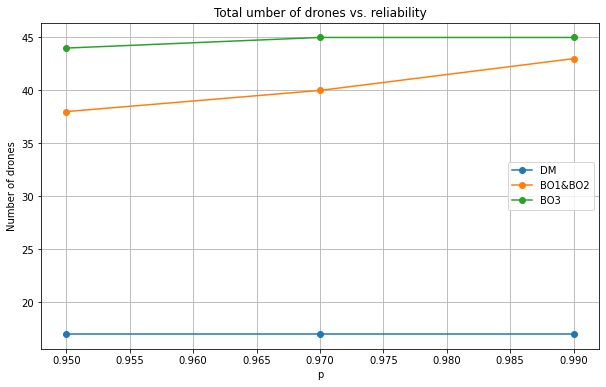

In [73]:
import matplotlib.pyplot as plt
import pandas as pd

# Data from the image
data = {
    'p': [0.95, 0.97, 0.99],
    'DM': [17, 17, 17],
    'BO1&BO2': [38, 40, 43],
    'BO3': [44, 45, 45]
}

# Create DataFrame
df = pd.DataFrame(data)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(df['p'], df['DM'], marker='o', label='DM')
plt.plot(df['p'], df['BO1&BO2'], marker='o', label='BO1&BO2')
plt.plot(df['p'], df['BO3'], marker='o', label='BO3')


# Adding title and labels
plt.title('Total umber of drones vs. reliability')
plt.xlabel('p')
plt.ylabel('Number of drones')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

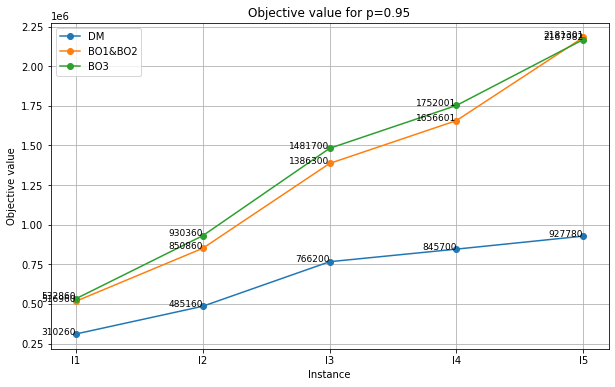

In [74]:
# Data from the image
data = {
    'Instance': ['I1', 'I2', 'I3', 'I4', 'I5'],
    'DM': [310260, 485160, 766200, 845700, 927780],
    'BO1&BO2': [516960, 850860, 1386300, 1656601, 2181301],
    'BO3': [532860, 930360, 1481700, 1752001, 2167982]
}

# Create DataFrame
df = pd.DataFrame(data)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(df['Instance'], df['DM'], marker='o', label='DM')
plt.plot(df['Instance'], df['BO1&BO2'], marker='o', label='BO1&BO2')
plt.plot(df['Instance'], df['BO3'], marker='o', label='BO3')

# Adding annotations
for i in range(len(df)):
    plt.text(df['Instance'][i], df['DM'][i], f'{df["DM"][i]}', fontsize=9, ha='right')
    plt.text(df['Instance'][i], df['BO1&BO2'][i], f'{df["BO1&BO2"][i]}', fontsize=9, ha='right')
    plt.text(df['Instance'][i], df['BO3'][i], f'{df["BO3"][i]}', fontsize=9, ha='right')

# Adding title and labels
plt.title('Objective value for p=0.95')
plt.xlabel('Instance')
plt.ylabel('Objective value')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()